In [ ]:

import wrds
import pandas as pd
import numpy as np
db = wrds.Connection(wrds_username='aanand99')

#Sourcing Data
db.raw_sql("select vixo, vixh, vixl, vix from cboe where date between '1992-11-01' and '2019-11-30' ")

In [4]:
res = db.raw_sql("select date, vixo, vixh, vixl, vix from cboe where date between '1992-11-01' and '2019-11-30' ")

In [5]:
res.to_csv("C:\Desktop\Academics\Third Sem\FE511\Vix.csv")

In [6]:
import matplotlib.pyplot as plt

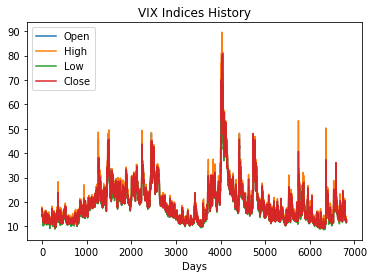

In [7]:
plt.figure()
plt.plot(res["vixo"])
plt.plot(res["vixh"])
plt.plot(res["vixl"])
plt.plot(res["vix"])
plt.title('VIX Indices History')
#plt.ylabel('Price (USD)')
plt.xlabel('Days')
#plt.xticks(res["date"])
plt.legend(['Open','High','Low','Close'], loc='upper left')
plt.show()

In [8]:
#Null values count
res.isna().sum()

date    0
vixo    3
vixh    3
vixl    3
vix     3
dtype: int64

In [9]:
len(res)

6821

In [10]:
#Dropping null values
res = res.dropna(how='any',axis=0)

In [11]:
len(res)

6818

In [12]:
res.isna().sum()

date    0
vixo    0
vixh    0
vixl    0
vix     0
dtype: int64

In [13]:
#Scaling and splitting data
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

train_cols = ["vixo","vixh","vixl","vix"]
res_train, res_test = train_test_split(res, train_size=0.8, test_size=0.2, shuffle=False)
print("Train and Test size", len(res_train), len(res_test))
# scale the feature MinMax, build array
x = res_train.loc[:,train_cols].values
min_max_scaler = MinMaxScaler()
x_train = min_max_scaler.fit_transform(x)
x_test = min_max_scaler.transform(res_test.loc[:,train_cols])

Train and Test size 5454 1364


In [14]:
#Build time series format
TIME_STEPS=10
BATCH_SIZE = 32
from tqdm import tqdm
def build_timeseries(mat, y_col_index):
    dim_0 = mat.shape[0] - TIME_STEPS
    dim_1 = mat.shape[1]
    x = np.zeros((dim_0, TIME_STEPS, dim_1))
    y = np.zeros((dim_0,))
    
    for i in tqdm(range(dim_0)):
        x[i] = mat[i:TIME_STEPS+i]
        y[i] = mat[TIME_STEPS+i, y_col_index]
    print("length of time-series i/o",x.shape,y.shape)
    return x, y

In [15]:

def trim_dataset(mat, batch_size):
    no_of_rows_drop = mat.shape[0]%batch_size
    if(no_of_rows_drop > 0):
        return mat[:-no_of_rows_drop]
    else:
        return mat

In [16]:
#Converting data into training, testing, and validation sets
x_t, y_t = build_timeseries(x_train, 3)
x_t = trim_dataset(x_t, BATCH_SIZE)
y_t = trim_dataset(y_t, BATCH_SIZE)
x_temp, y_temp = build_timeseries(x_test, 3)
x_val, x_test_t = np.split(trim_dataset(x_temp, BATCH_SIZE),2)
y_val, y_test_t = np.split(trim_dataset(y_temp, BATCH_SIZE),2)

100%|██████████████████████████████████████████████████████████████████████████| 1354/1354 [00:00<00:00, 170553.42it/s]

length of time-series i/o (5444, 10, 4) (5444,)
length of time-series i/o (1354, 10, 4) (1354,)


In [17]:
#Modeling with keras LSTM
import tensorflow.keras
#import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
import tensorflow.keras.optimizers
#from tensorflow.keras import backend
lstm_model = Sequential()
lstm_model.add(LSTM(100, batch_input_shape=(BATCH_SIZE, TIME_STEPS, x_t.shape[2]), dropout=0.0, recurrent_dropout=0.0, stateful=True, kernel_initializer='random_uniform'))
lstm_model.add(Dropout(0.5))
lstm_model.add(Dense(20,activation='relu'))
lstm_model.add(Dense(1,activation='sigmoid'))
optimizer = tensorflow.keras.optimizers.RMSprop(lr=0.001)
lstm_model.compile(loss='mean_squared_error', optimizer=optimizer)

C:\Users\abhis\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [18]:
from tensorflow.keras import callbacks
import os
csv_logger = callbacks.CSVLogger(os.path.join("C:\\Desktop\\Academics\\Third Sem\\FE511\\aaa.log"), append=True)

history = lstm_model.fit(x_t, y_t, epochs=100, verbose=2, batch_size=BATCH_SIZE,
                    shuffle=False, validation_data=(trim_dataset(x_val, BATCH_SIZE),
                    trim_dataset(y_val, BATCH_SIZE)), callbacks=[csv_logger])

Train on 5440 samples, validate on 672 samples
Epoch 1/100
 - 3s - loss: 0.0156 - val_loss: 0.0045
Epoch 2/100
 - 2s - loss: 0.0064 - val_loss: 0.0040
Epoch 3/100
 - 2s - loss: 0.0050 - val_loss: 0.0040
Epoch 4/100
 - 2s - loss: 0.0043 - val_loss: 0.0039
Epoch 5/100
 - 2s - loss: 0.0028 - val_loss: 0.0031
Epoch 6/100
 - 2s - loss: 0.0023 - val_loss: 0.0027
Epoch 7/100
 - 2s - loss: 0.0019 - val_loss: 0.0025
Epoch 8/100
 - 2s - loss: 0.0018 - val_loss: 0.0023
Epoch 9/100
 - 2s - loss: 0.0016 - val_loss: 0.0020
Epoch 10/100
 - 2s - loss: 0.0014 - val_loss: 0.0022
Epoch 11/100
 - 2s - loss: 0.0013 - val_loss: 0.0020
Epoch 12/100
 - 2s - loss: 0.0012 - val_loss: 0.0019
Epoch 13/100
 - 2s - loss: 0.0012 - val_loss: 0.0017
Epoch 14/100
 - 2s - loss: 0.0012 - val_loss: 0.0013
Epoch 15/100
 - 2s - loss: 0.0011 - val_loss: 0.0014
Epoch 16/100
 - 2s - loss: 0.0011 - val_loss: 0.0013
Epoch 17/100
 - 2s - loss: 0.0011 - val_loss: 0.0012
Epoch 18/100
 - 2s - loss: 0.0010 - val_loss: 0.0011
Epoch 19

In [19]:

#Prediction
predicted_vix = lstm_model.predict(x_test_t)


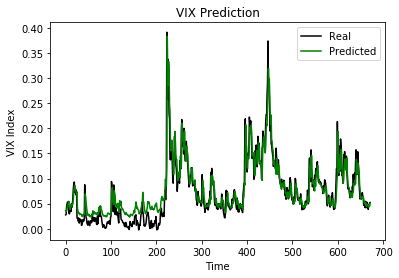

In [22]:
#Prediction plot
plt.plot(y_test_t, color = 'black', label = 'Real')
plt.plot(predicted_vix, color = 'green', label = 'Predicted')
plt.title('VIX Prediction')
plt.xlabel('Time')
plt.ylabel('VIX Index')
plt.legend()
plt.show()